# Lending Club - Interest Rate Predictor

## Current Notebook: 5_Model_Random Forest

---
**Author:** Rohit Singh
<br/>
[GitHub](https://github.com/RohitSinghHQ) | [LinkedIn](https://www.linkedin.com/in/RohitSinghHQ)
<br/>
<br/>
**Project:** Lending Club - Interest Rate Predictor
<br/>
<br/>
**Previous Notebook:** 4_Model_Decision Tree
<br/>
**Current Notebook:** 5_Model_Random Forest
<br/>
**Next Notebook:** 6_Model_XG Boost

## Table of Contents

[1. Data Import](#1)
<br/>
[2. Transformers](#2)
<br/>
[3. Random Forest: Model Training](#3)
<br/>
[4. Random Forest: Model Evaluation](#4)
<br/>
[5. Random Forest: Model Predictions](#5)
<br/>
[6. Observations](#6)

---
<a id="1"></a>
## 1. Data Import

In [2]:
# Import packages
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from tempfile import mkdtemp
import shap

Let us import the Train, Validation, Remainder, and Test data sets.

In [3]:
# Import Train, Validation, Remainder, Test sets

X_remainder = joblib.load('data/X_remainder.pkl')
X_train = joblib.load('data/X_train.pkl')
X_test = joblib.load('data/X_test.pkl')
X_validation = joblib.load('data/X_validation.pkl')

y_remainder = joblib.load('data/y_remainder.pkl')
y_train = joblib.load('data/y_train.pkl')
y_test = joblib.load('data/y_test.pkl')
y_validation = joblib.load('data/y_validation.pkl')

In [4]:
# Print shapes of split sets
print(f'Shape of Test set: {X_test.shape}')
print(f'Shape of Validation set: {X_validation.shape}')
print(f'Shape of Train set: {X_train.shape}')

Shape of Test set: (416057, 15)
Shape of Validation set: (332846, 15)
Shape of Train set: (1331380, 15)


Data sets seem to have loaded correctly.

---
<a id="2"></a>
### 2. Transformers

In [5]:
# Check categorical columns
cat_columns = list(X_train.select_dtypes(include=['object', 'category']).columns)
cat_columns
print(f'Categorical columns are: {cat_columns}')

Categorical columns are: ['term', 'purpose', 'verification_status', 'home_ownership', 'disbursement_method', 'pub_rec_bin', 'pub_rec_bankruptcies_bin', 'tax_liens_bin']


In [6]:
# Check numerical columns
num_columns = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
num_columns
print(f'Numerical columns are: {num_columns}')

Numerical columns are: ['loan_amnt', 'annual_inc', 'dti', 'open_acc', 'mort_acc', 'num_bc_sats', 'fico_range_avg']


**Why encode categorical data using OneHotEncoder?**

We have few categorical columns in our data. Since order is not important in these categorical columns, we can encode them using OneHotEncoder. If order was important, we would have used OrdinalEncoder.

In [7]:
# Set up categorical pipeline
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

**Why scale numerical data using StandardScaler?**

We have few numerical columns in our data with varying scales of measurement. Hence, it makes sense to scale the data so that all attributes have the same scale. This helps machine learning algorithms perform better.

We are aware that tree-based models do not require data to be scaled.

In [8]:
# Set up numerical pipeline
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

In [9]:
# Set up column transformer
col_transformer = ColumnTransformer([
    ('cat', cat_pipe, cat_columns),
    ('num', num_pipe, num_columns)],
    remainder='passthrough',
    n_jobs=-1,
    verbose=3
)
col_transformer.fit(X_train)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['term', 'purpose', 'verification_status',
                                  'home_ownership', 'disbursement_method',
                                  'pub_rec_bin', 'pub_rec_bankruptcies_bin',
                                  'tax_liens_bin']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['loan_amnt', 'annual_inc', 'dti', 'open_acc',
                                  'mort_acc', 'num_bc_sats',
                                  'fico_range_avg'])],
                  verbose=3)

Let us check whether OneHotEncoder properly encoded the categorical columns or not.

In [10]:
# Prepare column names
cat_columns_names = col_transformer.named_transformers_['cat']['encoder'].get_feature_names(cat_columns)
columns = np.append(cat_columns_names, num_columns)

# Check column names
display(X_train)
display(pd.DataFrame(col_transformer.transform(X_train), columns=columns))

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


,loan_amnt,term,purpose,annual_inc,verification_status,home_ownership,dti,open_acc,mort_acc,num_bc_sats,disbursement_method,fico_range_avg,pub_rec_bin,pub_rec_bankruptcies_bin,tax_liens_bin
237045,20000.0,60 months,debt_consolidation,85000.0,Verified,MORTGAGE,16.68,15.0,6.0,3.0,Cash,662.0,pub_rec_1+_bin,pub_rec_bankruptcies_1+_bin,tax_liens_0_bin
2066086,4000.0,36 months,home_improvement,112000.0,Source Verified,MORTGAGE,21.55,12.0,1.0,5.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1163134,35000.0,60 months,debt_consolidation,180000.0,Source Verified,MORTGAGE,15.55,23.0,1.0,12.0,Cash,757.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1189746,10000.0,36 months,debt_consolidation,66000.0,Not Verified,MORTGAGE,11.96,9.0,2.0,5.0,Cash,672.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
1078531,6000.0,36 months,car,40000.0,Not Verified,OWN,20.28,4.0,2.0,2.0,Cash,737.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1061037,30000.0,36 months,credit_card,130000.0,Source Verified,MORTGAGE,15.32,18.0,1.0,9.0,Cash,677.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
306590,28775.0,36 months,debt_consolidation,60000.0,Verified,MORTGAGE,18.56,8.0,1.0,5.0,Cash,697.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
850631,15000.0,36 months,credit_card,60000.0,Not Verified,RENT,21.82,9.0,0.0,6.0,DirectPay,702.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin
740312,35000.0,36 months,debt_consolidation,90000.0,Source Verified,MORTGAGE,15.93,6.0,1.0,2.0,Cash,682.0,pub_rec_0_bin,pub_rec_bankruptcies_0_bin,tax_liens_0_bin


,term_36 months,term_60 months,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,pub_rec_bankruptcies_bin_pub_rec_bankruptcies_1+_bin,tax_liens_bin_tax_liens_0_bin,tax_liens_bin_tax_liens_1+_bin,loan_amnt,annual_inc,dti,open_acc,mort_acc,num_bc_sats,fico_range_avg
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.566806,0.042796,-0.182339,0.582379,2.333721,-0.592870,-1.160244
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.201218,0.245596,0.394588,0.052904,-0.284009,0.062837,-0.695519
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.756349,-0.316205,1.994311,-0.284009,2.357812,1.783016
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.538209,-0.099914,-0.741496,-0.476570,0.239537,0.062837,-0.850427
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.980215,-0.295202,0.244137,-1.359027,0.239537,-0.920724,1.163382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331375,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.671822,0.380795,-0.343452,1.111853,-0.284009,1.374251,-0.695519
1331376,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.536457,-0.144981,0.040376,-0.653061,-0.284009,0.062837,-0.075885
1331377,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.014299,-0.144981,0.426574,-0.476570,-0.807555,0.390690,0.079023
1331378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.224329,0.080352,-0.271188,-1.006044,-0.284009,-0.920724,-0.540611


We can see that OneHotEncoder has successfully encoded Categorical columns.

We can also see that Numerical columns have been scaled.

---
<a id="3"></a>
### 3. Random Forest: Model Training

Having tried the Decision Tree model in the previous notebook, we will focus on the Random Forest model in this notebook to see if we can improve the model performance.

Instead of exploring multiple combinations one by one, we will use Pipeline and GridSearchCV/RandomizedSearchCV to find the best hyper-parameters for us. Ideally, we would have used Pipeline and GridSearchCV to try out all possible combinations. But due to the size of our data set and time/computing restraints, we will use Pipeline and RandomizedSearchCV for the time being. RandomizedSearchCV doesn't try out all possible combinations like GridSearchCV but only evaluates random combinations by selecting random values for each hyper-parameter.

**Scoring**

For scoring, we will RMSE (Root Mean Squared Error).

RMSE is an extension of the Mean Squared Error (MSE). The square root of the error is calculated, which means that the units of RMSE are the same as the original units of the target value that is being predicted.

RMSE represents the square root of the variance of the residuals. A perfect RMSE value is 0.0, which means that all predictions matched the expected values exactly. This is almost never the case.

In [10]:
%%time
# Run time ~ 60 hr 40 min

# Random Forest Regressor

# Cache memory in case of kernel crash
cachedir = mkdtemp()

# Set default values for pipeline
pipe = Pipeline([
        ('preprocessor', col_transformer),
        ('model', RandomForestRegressor())],
        memory=cachedir)

# Set up parameter grid
param_grid = [
    {
        # Random Forest Regressor
        'model': [RandomForestRegressor(n_estimators=100, random_state=123)],
        'model__max_depth': np.arange(5, 35, 5),
        'model__min_samples_leaf': np.arange(5, 100, 10),
    }  
]

# Store results of RandomizedSearchCV as `rf_grid`
rf_grid = RandomizedSearchCV(pipe, param_grid, n_iter=100, cv=5, scoring='neg_root_mean_squared_error',\
                          return_train_score=True, verbose=3)

# Fit grid on Train data
rf_fitgrid = rf_grid.fit(X_train, y_train)

The total space of parameters 60 is smaller than n_iter=100. Running 60 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


Persisting input arguments took 12.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.2s
[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   1.8s
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.849, test=-3.843) total time= 7.2min


Persisting input arguments took 13.44s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   1.9s
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.848, test=-3.858) total time= 7.2min


Persisting input arguments took 13.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   1.8s
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.847, test=-3.858) total time= 7.2min


Persisting input arguments took 13.44s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.1s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   1.8s
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.850, test=-3.847) total time= 7.1min


Persisting input arguments took 13.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   1.9s
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=5;, score=(train=-3.859, test=-3.853) total time= 7.2min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.849, test=-3.843) total time= 6.7min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.848, test=-3.858) total time= 6.7min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.847, test=-3.858) total time= 6.9min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=5, model__min_samples_leaf=15;, score=(train=-3.850, test=-3.847) total time= 6.9min
[CV 5/5] END model=RandomForestRegressor(random_s

[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=5;, score=(train=-3.635, test=-3.652) total time=10.9min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=15;, score=(train=-3.632, test=-3.650) total time=10.8min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=15;, score=(train=-3.632, test=-3.661) total time=10.7min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=15;, score=(train=-3.632, test=-3.659) total time=10.8min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=15;, score=(train=-3.634, test=-3.650) total time=10.7min
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=10, model__min_samples_leaf=15;, score=(train=-3.637, test=-3.652) total time=10.7min
[CV 1/5] END model=Rand

[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=15;, score=(train=-3.440, test=-3.583) total time=12.7min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=15;, score=(train=-3.440, test=-3.591) total time=12.7min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=15;, score=(train=-3.439, test=-3.589) total time=12.6min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=15;, score=(train=-3.441, test=-3.579) total time=12.5min
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=15;, score=(train=-3.443, test=-3.579) total time=12.6min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=15, model__min_samples_leaf=25;, score=(train=-3.467, test=-3.585) total time=12.6min
[CV 2/5] END model=Ran

[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=15;, score=(train=-3.253, test=-3.585) total time=14.1min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=15;, score=(train=-3.252, test=-3.583) total time=14.0min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=15;, score=(train=-3.254, test=-3.574) total time=13.8min
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=15;, score=(train=-3.257, test=-3.572) total time=14.0min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=25;, score=(train=-3.351, test=-3.578) total time=13.7min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=20, model__min_samples_leaf=25;, score=(train=-3.350, test=-3.585) total time=13.6min
[CV 3/5] END model=Ran

[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=15;, score=(train=-3.171, test=-3.586) total time=14.0min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=15;, score=(train=-3.173, test=-3.576) total time=13.6min
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=15;, score=(train=-3.176, test=-3.574) total time=13.9min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=25;, score=(train=-3.315, test=-3.579) total time=13.4min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=25;, score=(train=-3.314, test=-3.586) total time=13.6min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=25, model__min_samples_leaf=25;, score=(train=-3.314, test=-3.584) total time=13.5min
[CV 4/5] END model=Ran

[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=15;, score=(train=-3.157, test=-3.577) total time=14.2min
[CV 5/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=15;, score=(train=-3.159, test=-3.575) total time=14.1min
[CV 1/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=25;, score=(train=-3.310, test=-3.579) total time=13.7min
[CV 2/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=25;, score=(train=-3.309, test=-3.587) total time=13.7min
[CV 3/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=25;, score=(train=-3.309, test=-3.585) total time=13.6min
[CV 4/5] END model=RandomForestRegressor(random_state=123), model__max_depth=30, model__min_samples_leaf=25;, score=(train=-3.312, test=-3.575) total time=13.6min
[CV 5/5] END model=Ran

Persisting input arguments took 16.40s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.2s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.2s
CPU times: user 2d 11h 34min 13s, sys: 19min 35s, total: 2d 11h 53min 49s
Wall time: 2d 12h 35min 57s


In [11]:
# Best estimator
print('Best Estimator: %s' % rf_fitgrid.best_estimator_)

Best Estimator: Pipeline(memory='/var/folders/c_/v_fkrbc17sgfc3pm6kln8_9w0000gn/T/tmp92dadk6a',
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['term', 'purpose',
                                                   'verification_status',
                                                   'home_ownership',
                                                   'disbursement_method',
                                                   'pub_rec_bin',
                                                   'pub_rec_bankruptcies_bin',
                            

In [12]:
# Export fit grid
joblib.dump(rf_fitgrid, 'data/rf_fitgrid.pkl')

['data/rf_fitgrid.pkl']

In [13]:
# Export fit grid best estimator
joblib.dump(rf_fitgrid.best_estimator_, 'data/rf_fitgrid_best_estimator.pkl')

['data/rf_fitgrid_best_estimator.pkl']

---
<a id="4"></a>
### 4. Random Forest: Model Evaluation

Let us import the exported fit grid model 'pkl' file for further evaluation.

In [11]:
# Load exported model
rf_fitgrid = joblib.load('data/rf_fitgrid.pkl')

In [12]:
# Best hyper-parameters
rf_fitgrid.best_estimator_.named_steps.model

RandomForestRegressor(max_depth=20, min_samples_leaf=15, random_state=123)

The best hyper-parameters selected by RandomizedSearchCV for Random Forest Regressor are:
- n_estimators = 100
- max_depth = 20
- min_samples_leaf = 15

In [13]:
# Best score
print('Best Score for Random Forest using RMSE scoring: %.4f' % rf_fitgrid.best_score_)

Best Score for Random Forest using RMSE scoring: -3.5783


In [14]:
# Grid cross validation results - All columns
pd.DataFrame(rf_fitgrid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__min_samples_leaf,param_model__max_depth,param_model,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,426.852795,4.256300,5.049007,0.589626,5,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 5, 'model__max_dep...",-3.843161,-3.857735,...,-3.851846,0.005850,53,-3.848518,-3.848300,-3.847333,-3.850434,-3.858634,-3.850644,0.004120
1,403.824349,6.414155,5.089664,0.532358,15,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 15, 'model__max_de...",-3.843161,-3.857735,...,-3.851846,0.005850,53,-3.848518,-3.848300,-3.847333,-3.850434,-3.858634,-3.850644,0.004120
2,405.234808,9.514332,5.147904,0.788022,25,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 25, 'model__max_de...",-3.843160,-3.857735,...,-3.851846,0.005850,52,-3.848520,-3.848300,-3.847333,-3.850434,-3.858634,-3.850644,0.004120
3,397.385634,2.107302,4.993134,0.907613,35,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 35, 'model__max_de...",-3.843157,-3.857735,...,-3.851845,0.005851,51,-3.848521,-3.848301,-3.847333,-3.850434,-3.858634,-3.850645,0.004119
4,395.822123,3.841257,5.672816,0.349662,45,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 45, 'model__max_de...",-3.843163,-3.857735,...,-3.851849,0.005848,55,-3.848534,-3.848301,-3.847333,-3.850442,-3.858641,-3.850650,0.004121
5,405.330273,4.630855,4.705376,0.764325,55,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 55, 'model__max_de...",-3.843170,-3.857735,...,-3.851855,0.005845,60,-3.848554,-3.848301,-3.847333,-3.850453,-3.858672,-3.850662,0.004130
6,390.399617,14.113918,5.202013,0.613778,65,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 65, 'model__max_de...",-3.843166,-3.857735,...,-3.851855,0.005846,59,-3.848569,-3.848303,-3.847333,-3.850453,-3.858679,-3.850668,0.004131
7,402.840350,6.433976,5.049405,0.745527,75,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 75, 'model__max_de...",-3.843151,-3.857735,...,-3.851852,0.005851,56,-3.848579,-3.848306,-3.847334,-3.850453,-3.858679,-3.850670,0.004130
8,401.123743,4.626592,4.686010,0.671158,85,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 85, 'model__max_de...",-3.843151,-3.857736,...,-3.851853,0.005851,57,-3.848580,-3.848306,-3.847334,-3.850454,-3.858679,-3.850671,0.004130
9,401.719420,5.411613,4.662881,0.479719,95,5,"RandomForestRegressor(max_depth=20, min_sample...","{'model__min_samples_leaf': 95, 'model__max_de...",-3.843147,-3.857736,...,-3.851853,0.005852,58,-3.848584,-3.848308,-3.847337,-3.850455,-3.858680,-3.850673,0.004129


In [15]:
# Grid cross validation results - Selected columns
pd.DataFrame(rf_fitgrid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]\
            .sort_values('rank_test_score').head(10)

,params,mean_train_score,mean_test_score,rank_test_score
31,"{'model__min_samples_leaf': 15, 'model__max_de...",-3.254192,-3.578318,1
32,"{'model__min_samples_leaf': 25, 'model__max_de...",-3.351632,-3.578832,2
42,"{'model__min_samples_leaf': 25, 'model__max_de...",-3.315404,-3.579602,3
52,"{'model__min_samples_leaf': 25, 'model__max_de...",-3.310576,-3.579819,4
33,"{'model__min_samples_leaf': 35, 'model__max_de...",-3.405084,-3.580493,5
41,"{'model__min_samples_leaf': 15, 'model__max_de...",-3.172793,-3.580691,6
43,"{'model__min_samples_leaf': 35, 'model__max_de...",-3.385258,-3.580769,7
53,"{'model__min_samples_leaf': 35, 'model__max_de...",-3.383406,-3.580855,8
51,"{'model__min_samples_leaf': 15, 'model__max_de...",-3.156324,-3.581456,9
30,"{'model__min_samples_leaf': 5, 'model__max_dep...",-3.000574,-3.582361,10


For the best score, we see that:
- `mean_train_score` = ~ -3.25
- `mean_test_score` = ~ -3.58

Let us look at Feature Importances.

Feature Importances show us how useful the specified features are at predicting the target variable (interest rate).

In [16]:
# Show Best Estimator Feature Importances as data frame
feature_imp_df = pd.DataFrame(rf_fitgrid.best_estimator_.named_steps.model.feature_importances_, index=columns).\
                                sort_values(by=0, ascending=False)
feature_imp_df.head(10)

,0
fico_range_avg,0.325042
term_60 months,0.258959
dti,0.084366
annual_inc,0.067008
loan_amnt,0.055326
purpose_credit_card,0.042687
verification_status_Verified,0.029513
open_acc,0.021897
mort_acc,0.021172
num_bc_sats,0.018650


[ColumnTransformer] ........... (2 of 2) Processing num, total=   0.3s
[ColumnTransformer] ........... (1 of 2) Processing cat, total=   2.2s


We tried to evaluate the impact of the features using [SHAP](https://shap.readthedocs.io/en/latest/) (SHapley Additive exPlanations) values. However, the TreeExplainer was taking a really long time (> 72 hr and still not complete). So, for the time being, we decided to not proceed with SHAP values for this model. It seems calculating SHAP values for Random Forest does take a long time, as noted [here](https://github.com/slundberg/shap/issues/838).

Now let us try to predict using Validation and Test sets.

---
<a id="5"></a>
### 5. Random Forest: Model Predictions

**Predict on Validation set**

In [17]:
# Predict on Validation set
pred = rf_fitgrid.best_estimator_.predict(X_validation)
print(pred)

[15.50113892 19.04712785 14.30829151 ... 12.33237277 17.37018853
 14.07722512]


In [18]:
# Predicted error
pred_error = y_validation - pred

In [19]:
# Show predicted error as a data frame
pd.DataFrame(pred_error)

,int_rate
2043400,-6.061139
1111111,-1.077128
1131976,-6.118292
1512342,-1.273821
749634,-1.712063
...,...
628988,-0.256576
274810,-0.903239
142964,1.657627
2222476,-3.380189


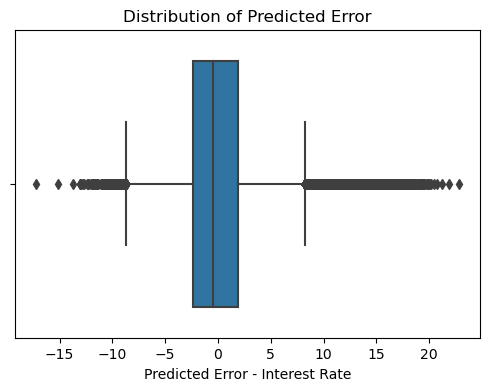

In [20]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

**Predict on Test set**

In [21]:
# Predict on Test set
pred = rf_fitgrid.best_estimator_.predict(X_test)
print(pred)

[16.46095566 16.64081712 11.55061886 ... 13.05052398 13.72094644
  9.45085309]


In [22]:
# Predicted error
pred_error = y_test - pred

In [23]:
# Actual vs Predicted interest rates
pd.DataFrame({'Actual': y_test, 'Predicted': pred, 'Error': pred_error})

,Actual,Predicted,Error
1592109,19.42,16.460956,2.959044
2103726,11.99,16.640817,-4.650817
2231437,13.49,11.550619,1.939381
1285218,14.16,14.096951,0.063049
296051,21.67,15.461487,6.208513
...,...,...,...
507968,6.08,8.356604,-2.276604
747744,9.75,8.980717,0.769283
295840,13.99,13.050524,0.939476
572988,12.62,13.720946,-1.100946


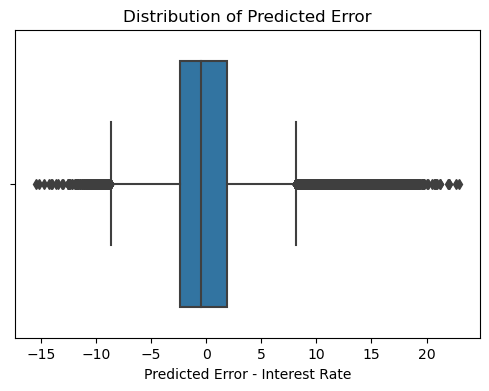

In [24]:
# Plot predicted error

# Create plot
plt.figure(figsize=(6,4))
sns.boxplot(data=pd.DataFrame(pred_error), x='int_rate')

# Set title, label, legend
plt.title('Distribution of Predicted Error')
plt.xlabel('Predicted Error - Interest Rate')

# Show plot
plt.show()

---
<a id="6"></a>
### 6. Observations

In [25]:
# Display Best Estimator top 10 Feature Importances data frame

display(feature_imp_df.head(10))

,0
fico_range_avg,0.325042
term_60 months,0.258959
dti,0.084366
annual_inc,0.067008
loan_amnt,0.055326
purpose_credit_card,0.042687
verification_status_Verified,0.029513
open_acc,0.021897
mort_acc,0.021172
num_bc_sats,0.018650


Let us create a table to see the top 10 Feature Importances side-by-side.

||**Decision Tree**|**Decision Tree**|**Random Forest**|
|-|-|-|-|
||**GridSearchCV**|**SHAP**|**GridSearchCV**|
|1|fico_range_avg|fico_range_avg|fico_range_avg|
|2|term_60 months|term_60_months|term_60 months|
|3|purpose_credit_card|purpose_credit_card|dti|
|4|dti|dti|annual_inc|
|5|annual_inc|annual_inc|loan_amnt|
|6|verification_status_Verified|verification_status_Verified|purpose_credit_card|
|7|loan_amnt|verification_status_Not Verified|verification_status_Verified|
|8|verification_status_Not Verified|mort_acc|open_acc|
|9|disbursement_method_DirectPay|loan_amnt|mort_acc|
|10|mort_acc|purpose_debt_consolidation|num_bc_sats|

Let us create a table for the RMSE scores.

||Best RMSE score|
|-|-|
|Model - Decision Tree Regressor (max_depth=15, min_samples_leaf=95)|-3.6514|
|Model - Random Forest Regressor (n_estimators=100, max_depth=20, min_samples_leaf=15)|-3.5783|

The best RMSE score for our best model (as of now) i.e. Random Forest Regressor (n_estimators=100, max_depth=20, min_samples_leaf=15) is ~ -3.58.

In the next Jupyter notebook (6_Model_XG Boost), we will focus on XG Boost model and see if we can improve the RMSE score.

**The End**